In [65]:
import data_loader
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
arr, reps, bills = data_loader.senate_records()

In [68]:
def getBillKey(bill):
    return 10000*int(bill["congress"]) + 1000*int(bill["session"]) + int(bill["vote_number"])
print(max([int(bill["congress"]) for bill in bills]))
print(max([int(bill["session"]) for bill in bills]))
print(max([int(bill["vote_number"]) for bill in bills]))

116
2
442


In [32]:
billkeys = [getBillKey(bill) for bill in bills]
indices = [i for i, _ in sorted(enumerate(billkeys), key=lambda x:x[1])]
bills = [bills[i] for i in indices]
arr = arr[:, indices]

Braun (R-IN)


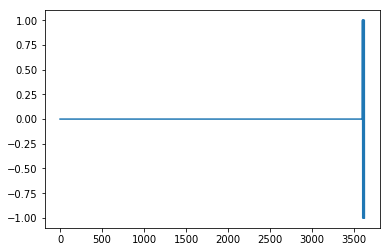

In [50]:
def infoRep(repid):
    print(reps[repid])
    plt.plot(arr[repid])
    plt.show()
    
infoRep(20)

In [79]:
# first bill of each session
firstbills = []
for bill in bills:
    if(bill["vote_number"] == "1"):
        firstbills.append(bill)
print(firstbills)

[{'question': 'On the Resolution', 'vote_title': 'S. Res. 19', 'congress_year': '2007', 'congress': '110', 'vote_document_text': 'A resolution honoring President Gerald Rudolph Ford.', 'vote_result_text': 'Resolution Agreed to (88-0)', 'session': '1', 'majority_requirement': '1/2', 'vote_date': 'January 8, 2007,  12:01 PM', 'vote_result': 'Resolution Agreed to', 'vote_number': '1', 'vote_question_text': 'On the Resolution S.Res. 19'}, {'vote_result': 'Bill Passed', 'congress_year': '2008', 'congress': '110', 'question': 'On Passage of the Bill', 'majority_requirement': '1/2', 'session': '2', 'vote_question_text': 'On Passage of the Bill H.R. 4986', 'vote_title': 'H.R.4986', 'vote_result_text': 'Bill Passed (91-3)', 'vote_number': '1', 'vote_date': 'January 22, 2008,  05:32 PM', 'vote_document_text': 'A bill to provide for the enactment of the National Defense Authorization Act for Fiscal Year 2008, as previously enrolled, with certain modifications to address the foreign sovereign immu

In [84]:
def filterReps(bill, inactiveThresh=10):
    """Find indices of representatives who have been around since bill.
    
    inactiveThresh specifies how many no-votes in a row indicate an inactive representative; default
    value is 10."""
    billkey = getBillKey(bill)
    goodreps = []
    for i in range(len(reps)):
        streak = 0
        isgood = True
        for j in range(len(bills)):
            if(getBillKey(bills[j]) >= billkey): # if more recent than billkey
                if(arr[i][j] == 0): streak += 1
                else: streak = 0
                if(streak == inactiveThresh): isgood = False
        if(isgood): goodreps.append(i)
    return goodreps

def billsSince(bill):
    """Count how many bills have transpired since input bill."""
    count = 0
    for b in bills:
        if getBillKey(b) >= getBillKey(bill):
            count += 1
    return count

In [78]:
print(filterReps(bills[0]))

[1, 21, 25, 28, 30, 31, 32, 41, 45, 51, 61, 74, 105, 112, 124, 141, 154, 159, 166, 171, 173, 186]


In [87]:
# how far back can we go while still having N active senators from then to today?
Ns = []
found = False
for i in range(len(firstbills)):
    Ns.append(len(filterReps(firstbills[i])))
Bs = [billsSince(bill) for bill in firstbills]

[[22, 3623], [24, 3181], [27, 2966], [29, 2569], [38, 2270], [38, 2035], [47, 1784], [48, 1493], [67, 1127], [71, 788], [79, 625], [85, 300], [100, 26]]


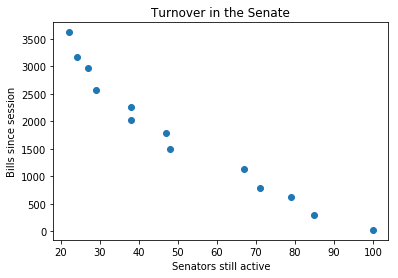

In [93]:
print([[Ns[i], Bs[i]] for i in range(len(Ns))])
plt.scatter(Ns, Bs)
plt.xlabel("Senators still active")
plt.ylabel("Bills since session")
plt.title("Turnover in the Senate")
plt.show()